In [1]:
import sys

import math
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import Robothym 

import os
import time
import serial

In [ ]:

from Thymio import Thymio

th = Thymio.serial(port='COM5', refreshing_rate=0.1)

In [ ]:
thym=Robothym.Robothym()
thym.setCurrPos((5,5,0))
# glob=[(5,4),(12,12.5),(13,13),(26,20)]
glob=[(5,0),(5,5),(0,5),(0,0)]
# glob=[(0.2, 0.2),(0.3,0.4),(0.6,1),(0.6,1.5),(0.4,1)]
thym.set_globalpath(glob)
x=[]
x.append(thym.getCurrPos())
i=0
node_index=0
# Ts=0.01
# thym.set_steptime(Ts)
next=glob[0]
thym.set_goal(next)
on_goal=False
speedy=[]
zibido=[]
print(next)
while on_goal==False:
    if thym.rho:
        if node_index < len(glob) and thym.rho < thym.on_node:   
            node_index+=1
            print(i)          
            if node_index < len(glob):
                next=glob[node_index] 
            thym.set_goal(next)            
            print(next)
        elif node_index >= len(glob) and thym.rho < thym.on_node:
            on_goal=True
            
    thym.ikine()
    left  = int(thym.phiL * thym.cm2thym)
    right = int(thym.phiR * thym.cm2thym)
    print(thym.phiL,thym.phiR)    
    left,right = thym.check_limits(left,right)
    left,right = thym.spd4thym(left,right)
    print(thym.getCurrPos())
    # th.set_var("motor.left.target", left)
    # th.set_var("motor.right.target", right)
    zibido.append([thym.rho, thym.alpha, thym.beta])
    # thym.run_on_thymio(th)
    
    thym.fkine()
    temp=thym.getCurrPos()
    x.append(temp)
    speedy.append([thym.phiL,thym.phiR])
    i+=1
    time.sleep(0.01)
    
# th.set_var("motor.left.target", 0)
# th.set_var("motor.right.target", 0)
speedy=np.array(speedy)
x=np.array(x)
path=np.array(glob)

In [ ]:
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

In [ ]:
node=thym.path[thym.node_index]
print(thym.node_index)
print(node)

In [2]:
thym=Robothym.Robothym()
thym.setCurrPos((0,0,0))
glob=[(0,0),(5,0),(5,5),(0,5),(0,0)]

thym.set_globalpath(glob)
x=[]
x.append(thym.getCurrPos())
i=0
thym.node_index=0
next=glob[1]
thym.set_goal(next)
on_goal=False
speedy=[]

while on_goal==False:
    curr=np.array(thym.curr_pos)
    line_angle=atan2(next[1],next[0])
    if abs(line_angle-curr[2])<0.5:
        thym.set_speed(50,2**16-50)    
    else:
        delta=thym.compute_dist(curr,next)
        dist=math.sqrt(delta[0]**2 + delta[1]**2)
        if dist < 0.5:
            


        
    # th.set_var("motor.left.target", left)
    # th.set_var("motor.right.target", right)
    thym.fkine()
    x.append(curr)
    speedy.append([thym.phiL,thym.phiR])

        
    

KeyboardInterrupt: 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

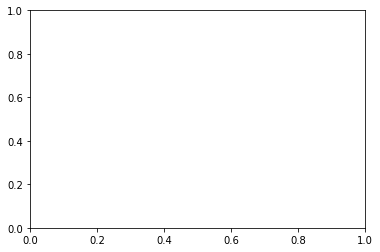

In [3]:
zibido=np.array(zibido)
plt.subplots()
plt.plot(zibido[:,0],'g',label='left')
plt.subplots()
plt.plot(zibido[:,1],'b',label='right')

plt.subplots()
plt.plot(zibido[:,2],'r',label='left')

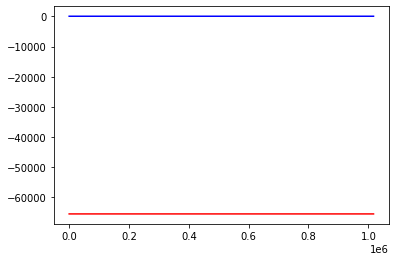

In [4]:
zibido=np.array(zibido)
speedy=np.array(speedy)
plt.plot(speedy[:,0],'b')
plt.plot(-speedy[:,1],'r')

In [15]:
x=np.array(x)
path=np.array(glob)
print(x)
print(x[:,1])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.37280000e+02  0.00000000e+00 -1.30292920e+02]
 ...
 [ 6.37978497e+02  8.31874164e+01 -1.32559626e+08]
 [ 7.67177282e+02 -6.42684110e+02 -1.32559757e+08]
 [ 3.30814201e+01 -7.11131639e+02 -1.32559887e+08]]
[   0.            0.            0.         ...   83.18741644 -642.68410967
 -711.13163911]


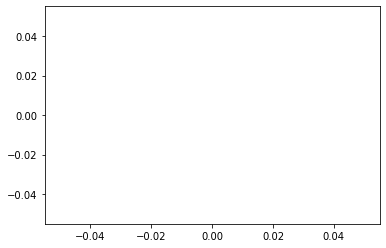

In [10]:
plt.plot(x[0,:],x[1,:],'b',label="traj")

In [8]:
figg1, (ax1) = plt.subplots()
ax1.plot(path[:,0],path[:,1],'r*',label="nodes")
ax1.plot(path[:,0],path[:,1],'r--',label="nodes")
ax1.plot(x[:,0],x[:,1],'b',label="traj")
ax1.set_xlabel('sampling time')
ax1.set_ylabel('trajectory')

figg1.legend(bbox_to_anchor=(0, 0.8))
plt.show()

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 432x288 with 1 Axes>

In [ ]:
theta=0
r=thym.wheel_radius
L=thym.wheel_length
pos=[[0,0,0]]
Ts=thym.Ts
x=0
y=0

for i in range(len(speedy)):
    temp=[0,0,0]
    R = np.array(((math.cos(theta),  -math.sin(theta), 0),
                  (math.sin(theta),  math.cos(theta),  0),
                  (      0,                  0,        1)))
    temp[0]=(r/2*speedy[i,0]+r/2*speedy[i,1])
    temp[1]=0
    temp[2]=(r/L/2*speedy[i,0]-r/L/2*speedy[i,1])
    temp=np.array(temp)
    ford = R.dot(temp.transpose())
    x+=ford[0]*Ts
    y+=ford[1]*Ts
    theta+=ford[2]*Ts

    pos.append((x,y,theta))
pos=np.array(pos)

In [ ]:
plt.plot(pos[:,0],pos[:,1])